<iframe width="560" height="315" src="https://www.youtube.com/embed/fAHkJ_Dhr50" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

https://youtu.be/fAHkJ_Dhr50

https://nbviewer.org/github/thu-vu92/the_witcher_network/blob/main/extracting_relationships.ipynb

In [1]:
import pandas as pd
import spacy
from spacy import displacy
import re
import time
import networkx as nx
import matplotlib.pyplot as plt
import os
import shutil
import networkx.algorithms.community as nx_comm


from IPython.core.display import display, HTML

/tmp/ipykernel_225111/234622817.py:13: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
! python -m spacy download en_core_web_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
if os.path.isdir('src/htmls'):
    shutil.rmtree('src/htmls')
os.makedirs('src/htmls')

In [4]:
character_df = pd.read_csv('data/character_df_cleaned.csv')

In [5]:
def remane_names(name):
    if name == 'Walter White Jr.':
        return re.sub(name, 'Walt Jr.', name)
    return name

In [6]:
character_df.Characters = character_df.Characters.apply(remane_names)
character_df['Characters_firstname'] = character_df.Characters.apply(lambda x : re.sub(r"'s", '', x.split()[0]))
character_df['Characters_lastname'] = character_df.Characters.apply(lambda x : re.sub(r"'s", '', x.split()[-1]))

character_df.head()

,Season,Characters,Characters_firstname,Characters_lastname
0,Season_1,Walter White,Walter,White
1,Season_1,Skyler White,Skyler,White
2,Season_1,Jesse Pinkman,Jesse,Pinkman
3,Season_1,Hank Schrader,Hank,Schrader
4,Season_1,Marie Schrader,Marie,Schrader


In [7]:
NER = spacy.load('en_core_web_sm')

In [8]:
with open('data/summaries/Season_5B.txt', 'r') as f:
    sea1_txt = f.read()

In [9]:
sea1_txt = sea1_txt.replace('\n', '\n. ')

In [10]:
ner1 = NER(sea1_txt)

In [11]:
# https://stackoverflow.com/a/51219483
# https://nanonets.com/blog/named-entity-recognition-with-nltk-and-spacy/ : For NLTK

displacy.render(ner1[:500], style = 'ent', jupyter = True)

In [12]:
entity_df = []

for sentence in ner1.sents:
    entity_lis = [ent.text for ent in sentence.ents]
    entity_df.append({'sentence' : sentence, 'entities' : entity_lis})
    
entity_df = pd.DataFrame(entity_df)
entity_df.head()

,sentence,entities
0,"(In, a, flashforward, ,, following, his, purch...","[M60, Walt]"
1,"(He, grabs, a, tire, iron, from, the, trunk, o...",[]
2,"(Trash, and, graffiti, are, everywhere, ;, a, ...",[]
3,"(Walt, notices, a, single, ,, spray, -, painte...",[Walt]
4,"(He, reaches, the, bedroom, and, retrieves, th...",[]


In [13]:
character_df.head()

,Season,Characters,Characters_firstname,Characters_lastname
0,Season_1,Walter White,Walter,White
1,Season_1,Skyler White,Skyler,White
2,Season_1,Jesse Pinkman,Jesse,Pinkman
3,Season_1,Hank Schrader,Hank,Schrader
4,Season_1,Marie Schrader,Marie,Schrader


In [14]:
def filter_entities(entity_list, char_df):
    
    return [entity for entity in entity_list
            if entity in list(char_df.Characters)
            or entity in list(char_df.Characters_firstname)
            or entity in list(char_df.Characters_lastname)]

In [15]:
entity_df['char_entities'] = entity_df.entities.apply(lambda x: filter_entities(x, character_df))
entity_df.head()

,sentence,entities,char_entities
0,"(In, a, flashforward, ,, following, his, purch...","[M60, Walt]",[Walt]
1,"(He, grabs, a, tire, iron, from, the, trunk, o...",[],[]
2,"(Trash, and, graffiti, are, everywhere, ;, a, ...",[],[]
3,"(Walt, notices, a, single, ,, spray, -, painte...",[Walt],[Walt]
4,"(He, reaches, the, bedroom, and, retrieves, th...",[],[]


In [16]:
entity_df = entity_df[entity_df['char_entities'].map(len) > 0]
entity_df.reset_index(inplace = True, drop = True)
entity_df.head()

,sentence,entities,char_entities
0,"(In, a, flashforward, ,, following, his, purch...","[M60, Walt]",[Walt]
1,"(Walt, notices, a, single, ,, spray, -, painte...",[Walt],[Walt]
2,"(After, exiting, the, house, ,, Walt, notices,...","[Walt, Carol]","[Walt, Carol]"
3,"(Hank, suffers, another, panic, attack, \n, .)",[Hank],[Hank]
4,"(A, stunned, Hank, leaves, the, bathroom, afte...","[Hank, Walt, Walt Whitman's, Grass]","[Hank, Walt]"


In [17]:
# https://stackoverflow.com/a/716489

for idx in range(entity_df.shape[0]):
    e_idx = min(idx+5, entity_df.shape[0])
    char_list = sum(entity_df.loc[idx:e_idx].char_entities, [])
    
    if idx % 220 == 0:
        print(char_list)

['Walt', 'Walt', 'Walt', 'Carol', 'Hank', 'Hank', 'Walt', 'Marie', 'Marie']
['Jesse', 'Brock', 'Jesse', 'Jesse', 'Walt', 'Jesse', 'Walt', 'Walt', 'Jack', 'Jesse']
['Lydia', 'Walt', 'Jesse', 'Walt', 'Jesse', 'Todd', 'Walt', 'Walt']


In [18]:
relationship = []

for idx in range(entity_df.shape[0]):
    e_idx = min(idx+5, entity_df.shape[0])
    char_list = sum(entity_df.loc[idx:e_idx].char_entities, [])

    unique_char = [char_list[i] for i in range(len(char_list)) if char_list[i] != char_list[i-1]]
    
    if idx % 220 == 0:
        print(char_list)
        print(unique_char)
        print('\n')

    if len(unique_char) > 1:
        for idx, a in enumerate(unique_char[:-1]):
            b = unique_char[idx + 1]
            relationship.append({'Source' : a, 'Destination' : b})

['Walt', 'Walt', 'Walt', 'Carol', 'Hank', 'Hank', 'Walt', 'Marie', 'Marie']
['Walt', 'Carol', 'Hank', 'Walt', 'Marie']


['Jesse', 'Brock', 'Jesse', 'Jesse', 'Walt', 'Jesse', 'Walt', 'Walt', 'Jack', 'Jesse']
['Brock', 'Jesse', 'Walt', 'Jesse', 'Walt', 'Jack', 'Jesse']


['Lydia', 'Walt', 'Jesse', 'Walt', 'Jesse', 'Todd', 'Walt', 'Walt']
['Lydia', 'Walt', 'Jesse', 'Walt', 'Jesse', 'Todd', 'Walt']




In [19]:
def name_correction(name):
    
    if name == 'Elliot' or name == 'Elliott Schwartz':
        return 'Elliott'
    
    if name == 'Gretchen Schwartz':
        return 'Gretchen'
    
    if name == 'Gale Boetticher':
        return 'Gale'
        
    if name == 'Gus':
        return 'Gus Fring'
        
    if name == 'Saul':
        return 'Saul Goodman'
    
    if name == 'Schrader' or name == 'Hank Schrader':
        return 'Hank'
    
    if name == 'Jesse Pinkman' or name == 'Pinkman':
        return 'Jesse'
    
    if name == 'Mike Ehrmantraut' or name == 'Ehrmantraut':
        return 'Mike'
    
    if name == 'Walter White' or name == 'White' or name == 'Whites' or name == 'Walt':
        return 'Walter'
    
    if name == 'Skyler White':
        return 'Skyler'
    
    return name

In [20]:
relationship_df = pd.DataFrame(relationship)
print(f"Shape of dataset 'relationship_df' :: {relationship_df.shape}\n")

relationship_df.Source = relationship_df.Source.apply(lambda x : name_correction(x))
relationship_df.Destination = relationship_df.Destination.apply(lambda x : name_correction(x))

relationship_df.head(20)

Shape of dataset 'relationship_df' :: (4468, 2)



,Source,Destination
0,Walter,Carol
1,Carol,Hank
2,Hank,Walter
3,Walter,Marie
4,Walter,Carol
5,Carol,Hank
6,Hank,Walter
7,Walter,Marie
8,Marie,Hank
9,Walter,Carol


In [21]:
relationship_df['Weight'] = 1
relationship_df = relationship_df.groupby(['Source', 'Destination'], sort=False, as_index=False).sum()
relationship_df.head(10)

,Source,Destination,Weight
0,Walter,Carol,3
1,Carol,Hank,3
2,Hank,Walter,183
3,Walter,Marie,39
4,Marie,Hank,50
5,Hank,Marie,77
6,Marie,Skyler,18
7,Skyler,Hank,38
8,Hank,Gale,6
9,Gale,Lydia,5


In [22]:
G = nx.from_pandas_edgelist(relationship_df, source = 'Source', target = 'Destination', edge_attr = 'Weight')

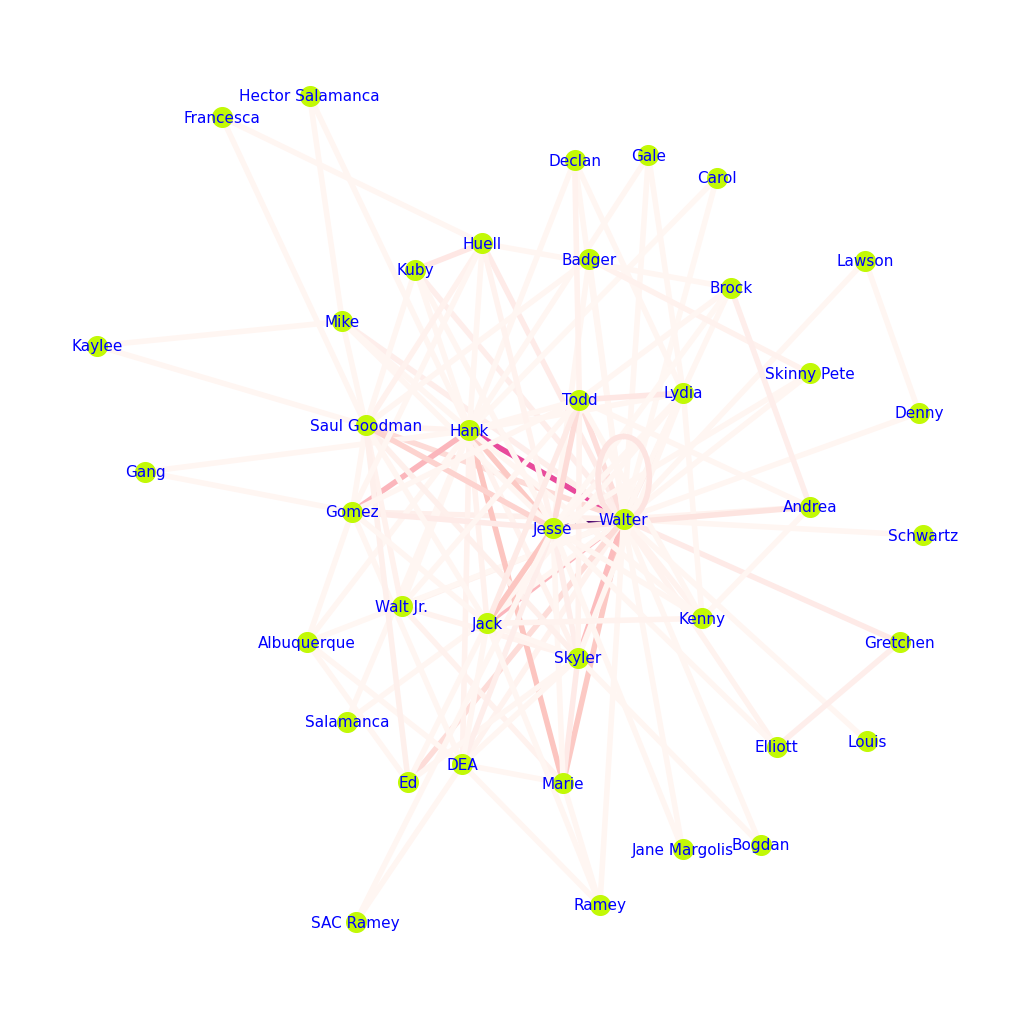

In [23]:
# https://stackoverflow.com/a/22971333
   
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)

node_degree = dict(G.degree)

nx.set_node_attributes(G, node_degree, 'size')

Weights =  nx.get_edge_attributes(G,'Weight').values()

arggs = {
        'with_labels' : 'True',
        'node_size' : 200,
        'node_color' : '#C2F906',
        'edge_color' : Weights, 
        "edge_cmap": plt.cm.RdPu,
        'width' : 4,
        'font_size' : 11,
        'font_color' : 'blue'
        }

nx.draw(G, pos = pos, **arggs)
plt.show()

In [24]:
# https://pyvis.readthedocs.io/en/latest/tutorial.html#example-visualizing-a-game-of-thrones-character-network

from pyvis.network import Network
net = Network(notebook = True, width = '950px', height = '800px', bgcolor = '#000000', font_color = 'white')

# node_degree = dict(G.degree)

# nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
# net.save_graph('src/htmls/S05B.html')
net.show('src/htmls/S05B.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [25]:
import community as community_louvain

In [26]:
partition = community_louvain.best_partition(G)
nx.set_node_attributes(G, partition, 'group')
print(f"Type of 'partition' :: {type(partition)}\n {partition}") 

Type of 'partition' :: <class 'dict'>
 {'Walter': 0, 'Carol': 1, 'Hank': 1, 'Marie': 2, 'Skyler': 1, 'Gale': 1, 'Lydia': 1, 'DEA': 2, 'Mike': 3, 'Hector Salamanca': 3, 'Jesse': 3, 'Skinny Pete': 3, 'Badger': 3, 'Saul Goodman': 3, 'Francesca': 3, 'Huell': 3, 'Kaylee': 3, 'Kuby': 3, 'Declan': 1, 'Todd': 1, 'Albuquerque': 2, 'Gomez': 2, 'Jack': 1, 'Kenny': 1, 'Walt Jr.': 1, 'Salamanca': 1, 'Brock': 3, 'Andrea': 3, 'Bogdan': 0, 'Gang': 2, 'Jane Margolis': 3, 'Ed': 2, 'SAC Ramey': 2, 'Ramey': 2, 'Louis': 0, 'Gretchen': 0, 'Elliott': 0, 'Schwartz': 0, 'Denny': 0, 'Lawson': 0}


In [27]:
net = Network(notebook = True, width = '950px', height = '800px', bgcolor = '#000000', font_color = 'white')
net.from_nx(G)
# net.save_graph('src/htmls/S05B_Communities.html')
net.show('src/htmls/S05B_Communities.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
